# 1. Importações

In [ ]:
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Base de dados de treinamento

In [ ]:
dataset, info = tfds.load('div2k', with_info=True, as_supervised=True)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.FZPD92_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.FZPD92_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_dataset = dataset['train']

In [ ]:
info

tfds.core.DatasetInfo(
    name='div2k',
    full_name='div2k/bicubic_x2/2.0.0',
    description="""
    DIV2K dataset: DIVerse 2K resolution high quality images as used for the
    challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)
    """,
    config_description="""
    Uses bicubic_x2 data.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    data_dir=PosixGPath('/tmp/tmptjbszg4vtfds'),
    file_format=tfrecord,
    download_size=4.68 GiB,
    dataset_size=4.68 GiB,
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=uint8),
        'lr': Image(shape=(None, None, 3), dtype=uint8),
    }),
    supervised_keys=('lr', 'hr'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=800, num_shards=64>,
        'validation': <SplitInfo num_examples=100, num_shards=8>,
    },
    citation="""@InProceedings{Agustsson_2017_CVPR_Workshops,
    	author = {Agustsson, Eirikur and Timofte, Radu},
    	title = {

In [ ]:
def preprocess(real_image, fake_image):
    real_image = tf.image.resize(real_image, [96, 96])
    fake_image = tf.image.resize(fake_image, [384, 384])
    real_image = tf.cast(real_image, tf.float32) / 255.0
    fake_image = tf.cast(fake_image, tf.float32) / 255.0
    return real_image, fake_image

In [ ]:
train_dataset = train_dataset.map(preprocess)

In [ ]:
train_dataset = train_dataset.shuffle(1000).batch(8)

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None))>

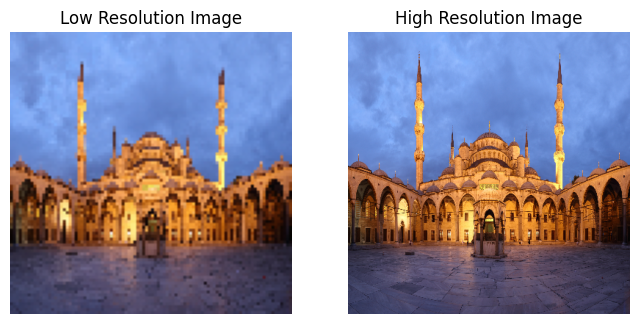

In [ ]:
for real_image, fake_image in train_dataset.take(1):

    real_image_np = real_image.numpy()
    fake_image_np = fake_image.numpy()

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.title('Low Resolution Image')
    plt.imshow(real_image_np[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('High Resolution Image')
    plt.imshow(fake_image_np[0])
    plt.axis('off')

    plt.show()

# Construção do gerador

In [ ]:
num_residual_blocks=16

In [ ]:
def make_esrgan_generator():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(96, 96, 3)))

    model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
    model.add(layers.PReLU(shared_axes=[1, 2]))

    for _ in range(num_residual_blocks):
        x = model.layers[-1].output
        res = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        res = layers.BatchNormalization()(res)
        res = layers.PReLU(shared_axes=[1, 2])(res)
        res = layers.Conv2D(64, kernel_size=3, padding='same')(res)
        res = layers.BatchNormalization()(res)
        x = layers.Add()([x, res])
        model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())

    for _ in range(2):
        model.add(layers.Conv2D(256, kernel_size=3, padding='same'))
        model.add(layers.UpSampling2D(size=2))
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(3, kernel_size=3, padding='same'))

    model.summary()
    return model

In [ ]:
generator = make_esrgan_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 p_re_lu (PReLU)             (None, 96, 96, 64)        64        
                                                                 
 activation (Activation)     (None, 96, 96, 64)        0         
                                                                 
 activation_1 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 activation_2 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 activation_3 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 activation_4 (Activation)   (None, 96, 96, 64)        0

# Construção do Discriminador

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(384, 384, 3)))

    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.summary()
    return model


In [ ]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 384, 384, 64)      1792      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 384, 384, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 batch_normalization_33 (Ba  (None, 192, 192, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 192, 192, 64)      0         
                                                                 
 conv2d_39 (Conv2D)          (None, 192, 192, 128)     73856     
                                                      

# Loss function e optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
vgg_model = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
def generator_loss(fake_output, generated_images, fake_images):
    adversarial_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    real_features = vgg_model(real_image)
    fake_features = vgg_model(fake_image)
    fake_features = tf.image.resize(fake_features, real_features.shape[1:3])
    content_loss = tf.reduce_mean(tf.abs(real_features - fake_features))

    total_gen_loss = adversarial_loss + 0.006 * content_loss
    return total_gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Treinamento

In [ ]:
@tf.function
def train_steps(real_images, fake_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(real_images, training=True)

        real_output = discriminator(fake_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output, generated_images, fake_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = generator(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        generated_image = tf.clip_by_value(predictions[i, :, :, :] * 127.5 + 127.5, tf.uint8)
        plt.imshow(generated_image)
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix =  os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
epochs = 50
noise_dim = 96
num_examples_to_generate = 2

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([2, 96])

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for real_images, fake_images in train_dataset:
      train_steps(real_images, fake_images)


    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch+1} is {time.time() - start} sec')

  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs + 1, seed)

In [ ]:
train(train_dataset, epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
generator.save('esrgan_generator.h5')